# Timon Dev

## Import and  Load Data

In [1]:
# imports
import time

tic = time.time()

import pandas as pd
import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import pyleoclim as pyleo

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot
import geoviews as gv
import holoviews
from geoviews import Dataset as gvDataset
import geoviews.feature as gf
from geoviews import Image as gvImage

from datatree import DataTree
from xmip.postprocessing import _parse_metric
import cartopy as cart
import cartopy.crs as ccrs
import random
import pooch
import os
import tempfile

import geopy
import geopy.distance


In [2]:
# helper functions

def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/Projects/Heatwaves' # this is different for each day
    user_temp_cache=tempfile.gettempdir()
    
    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file

In [3]:
# @title Figure settings
import ipywidgets as widgets  # interactive display

%config InlineBackend.figure_format = 'retina'
plt.style.use(
    "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
)
# model_colors = {k:f"C{ki}" for ki, k in enumerate(source_ids)}
%matplotlib inline

In [4]:
# loading CMIP data

col = intake.open_esm_datastore(
    "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
)  # open an intake catalog containing the Pangeo CMIP cloud data

# pick our five example models
# There are many more to test out! Try executing `col.df['source_id'].unique()` to get a list of all available models
source_ids = ['MPI-ESM1-2-LR']#['MRI-ESM2-0']
variable_ids = ["tas"]#["tas", "pr"]
# sorted(col.df["source_id"].unique())

In [5]:
# from the full `col` object, create a subset using facet search
cat = col.search(
    source_id=source_ids,
    variable_id= variable_ids,
    member_id="r1i1p1f1",
    table_id="3hr",
    grid_label="gn",
    experiment_id=["historical"],  # add scenarios if interested in projection
    require_all_on=[
        "source_id"
    ],  # make sure that we only get models which have all of the above experiments
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(
        use_cftime=True
    ),  # ensure all datasets use the same time index
    storage_options={
        "token": "anon"
    },  # anonymous/public authentication to google cloud storage
)

cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt = cat.to_datatree(**kwargs)
dt


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


DataTree('None', parent=None)
└── DataTree('MPI-ESM1-2-LR')
    └── DataTree('historical')
            Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 482120, y: 96,
                                 x: 192, bnds: 2, vertex: 4)
            Coordinates:
                height          float64 2.0
              * y               (y) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
              * x               (x) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
              * time            (time) object 1850-01-01 03:00:00 ... 2015-01-01 00:00:00
                lat_bounds      (y, bnds, x) float64 dask.array<chunksize=(96, 2, 192), meta=np.ndarray>
                lon_bounds      (x, bnds, y) float64 dask.array<chunksize=(192, 2, 96), meta=np.ndarray>
                lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.1 358.1 358.1
                lat             (x, y) float64 -88.57 -86.72 -84.86 ... 84.86 86.72 88.57
                lon_verticies   (vertex, x, y) float64 dask.array<chunksize=(1, 192, 96), meta=np.ndarray>
                lat_verticies   (vertex, x, y) float64 dask.array<chunksize=(1, 192, 96), meta=np.ndarray>
              * member_id       (member_id) object 'r1i1p1f1'
              * dcpp_init_year  (dcpp_init_year) float64 nan
            Dimensions without coordinates: bnds, vertex
            Data variables:
                tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 1456, 96, 192), meta=np.ndarray>
            Attributes: (12/63)
                Conventions:                      CF-1.7 CMIP-6.2
                activity_id:                      CMIP
                branch_method:                    standard
                branch_time_in_child:             0.0
                branch_time_in_parent:            0.0
                cmor_version:                     3.5.0
                ...                               ...
                intake_esm_attrs:variable_id:     tas
                intake_esm_attrs:grid_label:      gn
                intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-...
                intake_esm_attrs:version:         20190710
                intake_esm_attrs:_data_format_:   zarr
                intake_esm_dataset_key:           MPI-ESM1-2-LR/historical

In [6]:
# select just a single model and experiment
tas_historical = dt[source_ids[0]]["historical"].ds.tas
print("The time range is:")
print(
    tas_historical.time[0].data.astype("M8[h]"),
    "to",
    tas_historical.time[-1].data.astype("M8[h]"),
)

## select just a single model and experiment
#pr_historical = dt[source_ids[0]]["historical"].ds  # .pr
#print("The time range is:")
#print(
#    pr_historical.time[0].data.astype("M8[h]"),
#    "to",
#    pr_historical.time[-1].data.astype("M8[h]"),
#)


The time range is:
1850-01-01T03 to 2015-01-01T00


## Functions

In [7]:
# Select a region around a given point
def select_region_by_centerpoint(point, region_size):
    """
    point: tupel with (latitude: -90 to 90, longitude: 360) in coordinates
    region_size: tupel with (width, height) in km
    
    return: tuple of latitudes (north, south), tuple of longitudes (east, west)
    """
    
    lat, lon = point
    width, height = region_size
    
    # Define starting point.
    start = geopy.Point(lat, lon)

    # Define geo-distance objects
    dist_width = geopy.distance.geodesic(kilometers=width/2) 
    dist_height = geopy.distance.geodesic(kilometers=height/2)
    
    # Get latitudes and longitudes
    lat_north = dist_height.destination(point=start, bearing=0).latitude
    lat_south = dist_height.destination(point=start, bearing=180).latitude
    lon_east = dist_width.destination(point=start, bearing=90).longitude
    lon_west = dist_width.destination(point=start, bearing=270).longitude

    # Convert neg. longitudes (from -180 to 180) to pos. lons (from 0 to 360)
    if lon_west < 0:
        lon_west += 360
    if lon_east < 0:
        lon_east += 360
        
    return (lat_north, lat_south), (lon_east, lon_west)

select_region_by_centerpoint((0,0), region_size=(400,400))

((1.808732921924237, -1.808732921924237),
 (1.7966305682390433, 358.20336943176096))

In [8]:
def get_kmsize_of_latlon_defined_region(lat, lon):
    """
    lat: latitudes of region (lat_south, lat_north) (latitude: -90 to 90)
    lon: longitude of region (lat_east, lat_west) (longitude: 0 to 360)
    
    return: width_s(outh), width_n(orth), height_e(ast), height_w(est) (in km)
    """
    lat_south, lat_north = lat
    lon_east, lon_west = lon
    
    #  Define points by clockwise rotation starting at (A=top-right)
    A = geopy.Point(lat_north, lon_east)
    B = geopy.Point(lat_south, lon_east)
    C = geopy.Point(lat_south, lon_west)
    D = geopy.Point(lat_north, lon_west)
    
    # Distances
    width_n = geopy.distance.distance(D, A).km
    width_s = geopy.distance.distance(C, B).km
    height_e = geopy.distance.distance(A, B).km
    height_w = geopy.distance.distance(D, C).km
    
    return width_s, width_n, height_e, height_w

get_kmsize_of_latlon_defined_region(lat=(25, 65), lon=(20, 40))

(2017.1529342818603, 939.5723950348084, 4445.284948161982, 4445.284948161982)

In [9]:
if False:
    tas_heat_cells = tas_daily_mean.where(tas_grtr_P95).sel(time="2000-01-01").squeeze()
    
    def plot_global_temperature_map(ds):
        fig, ax_present = plt.subplots(
                figsize=[12, 6], subplot_kw={"projection": ccrs.Robinson()}
            )
        ds.plot(ax=ax_present, transform=ccrs.PlateCarree(), cmap="magma", robust=True)
        ax_present.coastlines()
        ax_present.add_feature(cart.feature.OCEAN, zorder=100, edgecolor='k')
        ax_present.set_title("")
        plt.show()
    
    plot_global_temperature_map(tas_heat_cells)

In [10]:
def count_cells(ds):
    x = ds.x.shape[0]
    y = ds.y.shape[0]
    return x * y

def count_true_cells_in_mask(ds_mask):
    return ds_mask.sum().to_numpy()

## Count cells

In [11]:
w_day = 10
area = 200 # km^2, minimum area over which tas>P95 for heatwave to exist
X = 5 # days, minimum number of days for which tas(area)>P95 for heatwave to exist
year_start = "2000-01-01"
year_end = "2001-12-31"

#Compute daily mean from
tas_selected = tas_historical.squeeze().sel(time=slice(year_start, year_end))
tas_daily_mean = tas_selected.resample(time='D').mean(dim='time')
tas_rolling_P95 = tas_daily_mean.chunk(dict(time=-1)).quantile(.95, dim='time')

# Create Boolean mask
tas_grtr_P95 = tas_daily_mean>tas_rolling_P95


In [12]:
tas_selected = tas_historical.sel(time=slice(year_start, year_end)).squeeze()
tas_daily_mean = tas_selected.resample(time='D').mean(dim='time')
tas_rolling_P95 = tas_daily_mean.rolling(time=w_day, center=True).mean().chunk(time=-1).quantile(.95, dim='time')
tas_grtr_P95 = tas_daily_mean>tas_rolling_P95

In [13]:
# Define the slice of x and y coordinates you want to select
x_slice = slice(25, 65)  # Longitude Range: Approximately 25°E to 65°E
y_slice = slice(20, 40)   # Latitude Range: Approximately 20°N to 40°N

tas_daily_mean_ME = tas_daily_mean.sel(x=x_slice, y=y_slice)
tas_grtr_P95_ME = tas_grtr_P95.sel(x=x_slice, y=y_slice)

# Apply mask
tas_daily_mean_masked = tas_daily_mean_ME.where(tas_grtr_P95_ME)

# Select Specific Day
day = "2000-07-15"
tas_daily_mean_day = tas_daily_mean_masked.sel(time=day).squeeze()
tas_grtr_P95_day = tas_grtr_P95_ME.sel(time=day).squeeze()

In [14]:
print("Cells in region",  count_cells(tas_grtr_P95_day) )
print("Heat cells in region",  count_true_cells_in_mask(tas_grtr_P95_day))

Cells in region 210
Heat cells in region 34


In [15]:
def count_cells(ds):
    """Counts the number of cells in a data set"""
    x = ds.x.shape[0]
    y = ds.y.shape[0]
    return x * y


def count_true_cells_in_mask(ds_mask):
    """Counts the number of heat cells in a data set"""
    return ds_mask.sum().to_numpy()


def get_heat_waves_from_date(tas_daily_mean_masked,
                            tas_grtr_P95_ME,
                            start_date=(2000, 7, 15), 
                            nb_days=5, 
                            threshold=0.25,
                            verbose=False,
                            plotting=False,
                           ):
    """
    Calculates the percentage of heat days over a give number of days.
    
    tas_daily_mean_masked: masked daily mean values
    tas_grtr_P95_ME: mask
    start_date: date at which to start looking for heatwaves
    nb_days: number of days necessary to count as a heatwave
    threshold: detection threshold for heatwave
    """

    year, month, day = start_date
    start_date = datetime.date(year, month, day)

    count_cells_all_days = 0
    count_heat_cells_all_days = 0

    for day_i in range(nb_days):
        t = start_date + datetime.timedelta(days=day_i)
        t = t.strftime('%Y-%m-%d')

        tas_daily_mean_day = tas_daily_mean_masked.sel(time=t).squeeze()
        tas_grtr_P95_day = tas_grtr_P95_ME.sel(time=t).squeeze()

        count_cells_all_days += count_cells(tas_grtr_P95_day)
        count_heat_cells_all_days += count_true_cells_in_mask(tas_grtr_P95_day)

        if plotting is True:
            fig, ax_present = plt.subplots(figsize=[8, 4], subplot_kw={"projection": ccrs.Robinson()})
            tas_daily_mean_day.plot(ax=ax_present, transform=ccrs.PlateCarree(), cmap="magma", robust=True)
            ax_present.coastlines()
            ax_present.add_feature(cart.feature.OCEAN, zorder=100, edgecolor='k')
            ax_present.set_title("Day" + str(day_i))
            plt.show()

    # Calculate percentage of heat cells over given number of days
    heat_cell_perc = count_heat_cells_all_days / count_cells_all_days
    heat_wave_detect = heat_cell_perc > threshold
    
    if verbose is True:
        print("Date: ", start_date.strftime('%Y-%m-%d'), " to ", t)
        print("Number of days: ", nb_days)
        print("Heat Wave Detected:", heat_wave_detect)
        print("Threshold of: ", str(threshold*100) + "%")
        print("Heat Cell Perc", str(np.round(heat_cell_perc, 2)*100) + "%")
        print("Nb Heat Cells", count_heat_cells_all_days)
        print("Nb Cells", count_cells_all_days)
        
        
    return heat_wave_detect, heat_cell_perc
        

if False:
    get_heat_waves_from_date(tas_daily_mean_masked,
                                       tas_grtr_P95_ME,
                                       start_date=(2000, 7, 15), 
                                       nb_days=5, 
                                       threshold=0.25,
                                       verbose=True,
                                       plotting=True,
                                       )

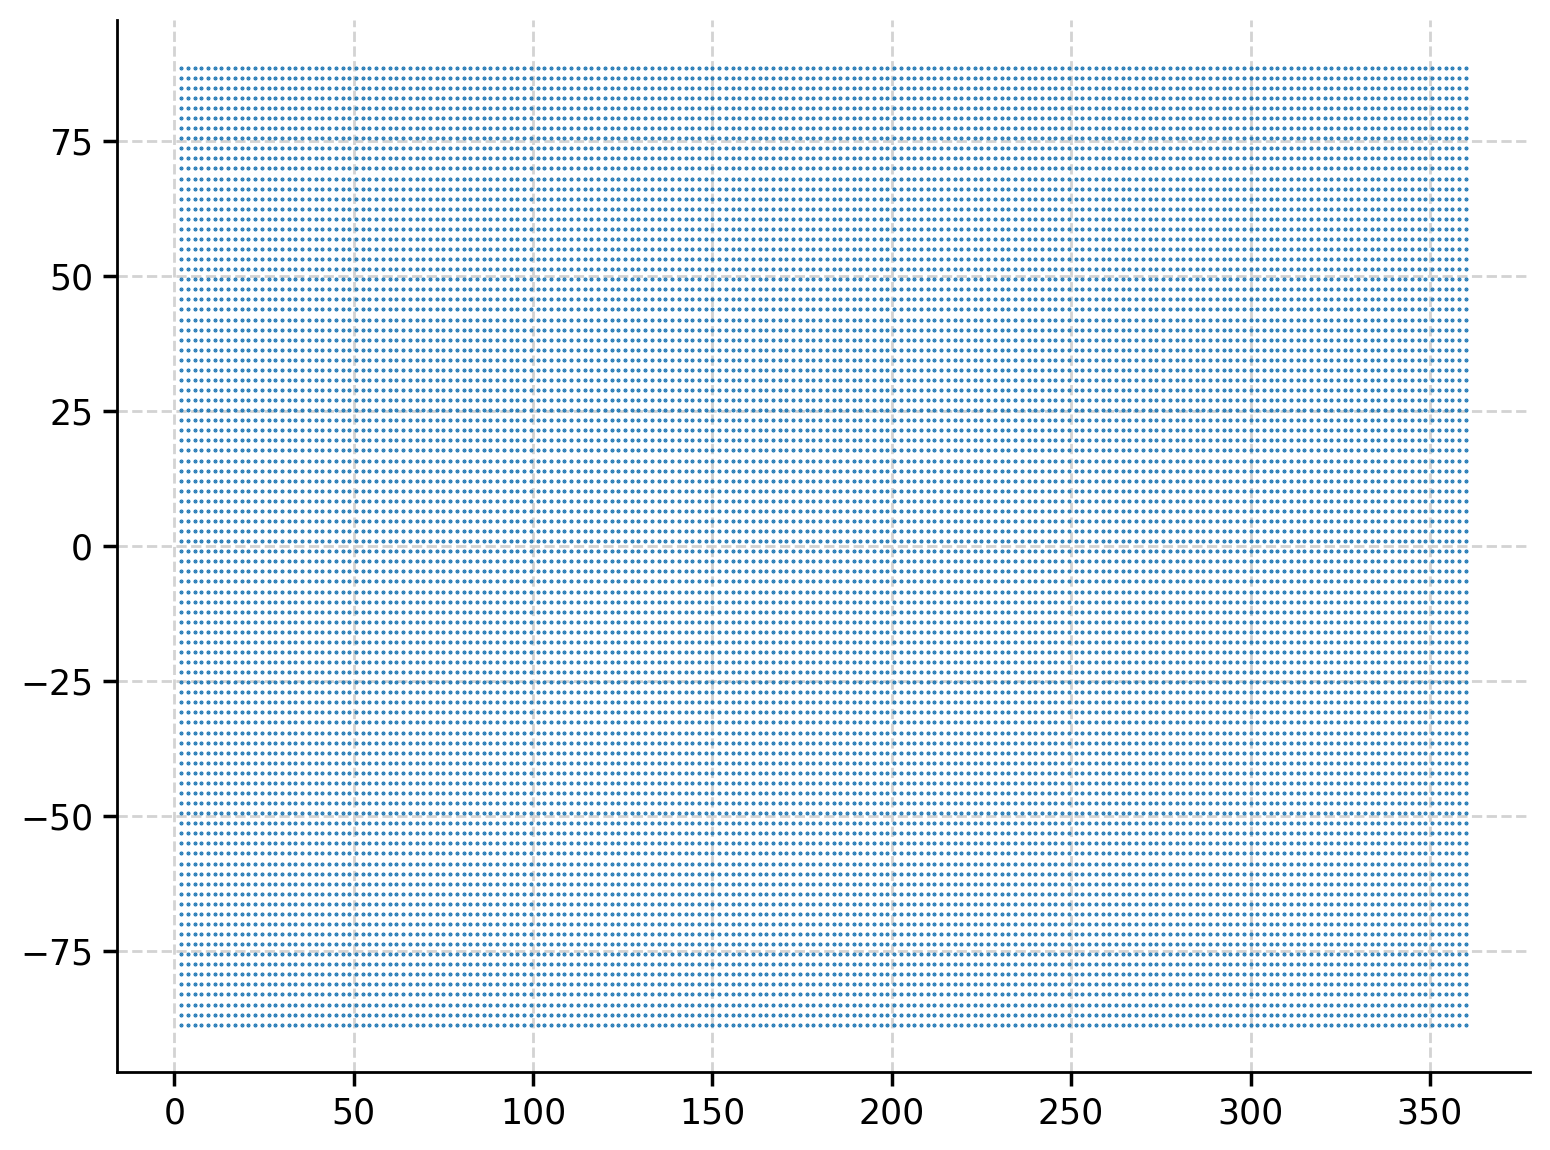

In [16]:
# Grid is rectangular
ds = tas_daily_mean.sel(time="2001-01-01").squeeze()
fig, ax = plt.subplots()
ax.scatter(x=ds.lon, y=ds.lat, s=0.2)

In [62]:



#For a rectangular grid the cosine of the latitude is 
# proportional to the grid cell area.
weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"


lat1 = -0.9326
lon2 = 360.0
lat2 = lat1
lon2 = 1.875

weights.sel(y=lat1, x=lon1, method="nearest") 
weights.sel(y=-lat2, x=lon2, method="nearest")

max_cell_length = get_distance_km(lat1, lon1, lat2, lon2)
max_cell_area = max_cell_length**2
max_cell_area

43554.26203954675

In [75]:
def get_distance_km(lat1, lon1, lat2, lon2):
    """Calculate distance in kilometers between two lat-long points.
    """
    # Create two points
    A = geopy.Point(lat1, lon1)
    B = geopy.Point(lat2, lon2)

    # Calculate the distance between the two points
    dist_km = geopy.distance.distance(A, B).km
    
    return dist_km 


def get_weights(ds):
    """For a rectangular grid the cosine of the latitude 
    is proportional to the grid cell area.
    """
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
 
    return weights


def get_max_cell_area_kmsqr(ds):
    """Calculate the difference in square km between two
    neightboring cells that have a weight of 1 (largest).
    """
    # Get geo-distance between random neighboring points on 
    # lat=-0.9326 which is axis of largest cells
    lat1 = -0.9326
    lon1 = 360.0
    lat2 = lat1
    lon2 = 1.875

    #weights.sel(y=lat1, x=lon1, method="nearest") 
    #weights.sel(y=-lat2, x=lon2, method="nearest")

    max_cell_length = get_distance_km(lat1, lon1, lat2, lon2)
    
    # area as sqared length
    max_cell_area = max_cell_length**2
    
    return max_cell_area


def get_area_of_cell_kmsqr(ds, cell_lat, cell_lon):
    """Since weights have values from 0 to 1, we can
    get the cell km^2-area by weighting with max 
    cell area.
    """
    area = get_weights(ds)*get_max_cell_area_kmsqr(ds)
    area.name = "area"
 
    cell_area = area.sel(y=cell_lat, x=cell_lon, method="nearest")

    return cell_area

ds = tas_daily_mean.sel(time="2001-01-01").squeeze()
cell_area = get_area_of_cell_kmsqr(ds, cell_lat=-0.9326, cell_lon=360.0)
print(np.sqrt(cell_area).to_numpy)  # kn km^2
print(cell_area)


<bound method DataArray.to_numpy of <xarray.DataArray 'area' ()>
array(208.68275489)
Coordinates:
    height          float64 2.0
    y               float64 -0.9326
    x               float64 358.1
    lon             float64 358.1
    lat             float64 -0.9326
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
    time            object 2001-01-01 00:00:00>
<xarray.DataArray 'area' ()>
array(43548.49218928)
Coordinates:
    height          float64 2.0
    y               float64 -0.9326
    x               float64 358.1
    lon             float64 358.1
    lat             float64 -0.9326
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
    time            object 2001-01-01 00:00:00


In [72]:
cell_y=1
cell_x=47
# WTF error

(area.sel(y=-86.72253095, x=88.125, method="nearest") == area[cell_y, cell_x]).to_numpy() # False
(area.sel(y=-86.72253095, x=88.125, method="nearest") == area[cell_x, cell_y]).to_numpy() # True  # weird
#(ds.sel(y=-86.72253095, x=88.125, method="nearest") == ds[cell_y, cell_x]).to_numpy()  # True

array(True)

In [ ]:
# TODO: add function for computing area
import datetime
from scipy.ndimage.measurements import label
import sys
def heatwave_over_region(tas_region, 
                         P95_mask_region, 
                         E, X, 
                         start_date=(2010, 7, 15), 
                         plotting=True,
                         mask_ocean=False):
    """
    tas_region: daily mean temperature of the region of interest for the year "year_ofinterest"
    P95_mask_region: mask of the region of interest for the year "year_ofinterest"
    E: minimum area (km^2) with tas>P95 for heatwave
    X: minimum number of days over which tas>P95
    """
    
    lat, lon, time = P95_mask_region.indexes.values()
    year, month, day = start_date
    start_date = datetime.date(year, month, day)
    end_date = datetime.date(year, month, day+X-1)
    # print((end_date.strftime('%Y-%m-%d')))
    tas_X_days = P95_mask_region.sel(time=slice(start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')))
    tas_X_days_numpy = np.nan_to_num(tas_X_days.as_numpy())
    ht_array, num_ht = label(np.prod(tas_X_days_numpy, axis=0))
    print(ht_array)
    print(num_ht)
    for ii in range(num_ht):
        coords = np.argwhere(ht_array==(ii+1))
        y = coords[:, 0]
        x = coords[:, 1]

        print(x, y)
        # area = compute_area(lon, lat) # add function for computing area
        area = 299 # dummy area
        if (area<E):
            ht_array[y, x]=0
    print(f"Number of heat waves recorded on the date {start_date}: {len(np.unique(ht_array))-1}")
    # uncomment if want to see output temperature array
    # print(np.nan_to_num(tas_region.sel(time=start_date.strftime('%Y-%m-%d')).squeeze().where(ht_array).as_numpy()))
    if plotting:
        fig, ax_present = plt.subplots(figsize=[8, 4], subplot_kw={"projection": ccrs.Robinson()})
        tas_region.sel(time=start_date.strftime('%Y-%m-%d')).squeeze().where(ht_array).plot(ax=ax_present, transform=ccrs.PlateCarree(), 
                                                                                            cmap="magma", robust=True)
        ax_present.coastlines()
        if mask_ocean:
            ax_present.add_feature(cart.feature.OCEAN, zorder=100, edgecolor='k')
        ax_present.set_title(f"Heatwaves on {start_date}")
        plt.show()

year_ofinterest = 2000
heatwave_over_region(tas_daily_mean_ME, 
                     tas_grtr_P95_ME, 
                     200, 
                     3, 
                     start_date=(year_ofinterest, 7, 15))

/tmp/ipykernel_14505/3424562424.py:3: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


[[0 6]
 [0 7]]
[0 0]
[6 7]
<xarray.DataArray 'area' ()>
array(162149.73260434)
Coordinates:
    height          float64 2.0
    y               float64 21.45
    x               float64 37.5
    lon             float64 37.5
    lat             float64 21.45
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
[[ 0 11]]
[0]
[11]
<xarray.DataArray 'area' ()>
array(40537.43315108)
Coordinates:
    height          float64 2.0
    y               float64 21.45
    x               float64 46.88
    lon             float64 46.88
    lat             float64 21.45
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
[[ 0 14]
 [ 0 15]
 [ 0 16]
 [ 0 17]
 [ 1 15]
 [ 1 16]
 [ 1 17]
 [ 1 18]
 [ 2 16]
 [ 2 17]
 [ 2 18]
 [ 2 19]
 [ 2 20]
 [ 3 16]
 [ 3 17]
 [ 3 18]
 [ 3 19]
 [ 3 20]]
[0 0 0 0 1 1 1 1 2 2 2 2 2 3 3 3 3 3]
[14 15 16 17 15 16 17 18 16 17 18 19 20 16 17 18 19 20]
<xarray.DataArray 'area' ()>
array(12837091.75995959)
Coordinates:
    height          float64 2.0
 

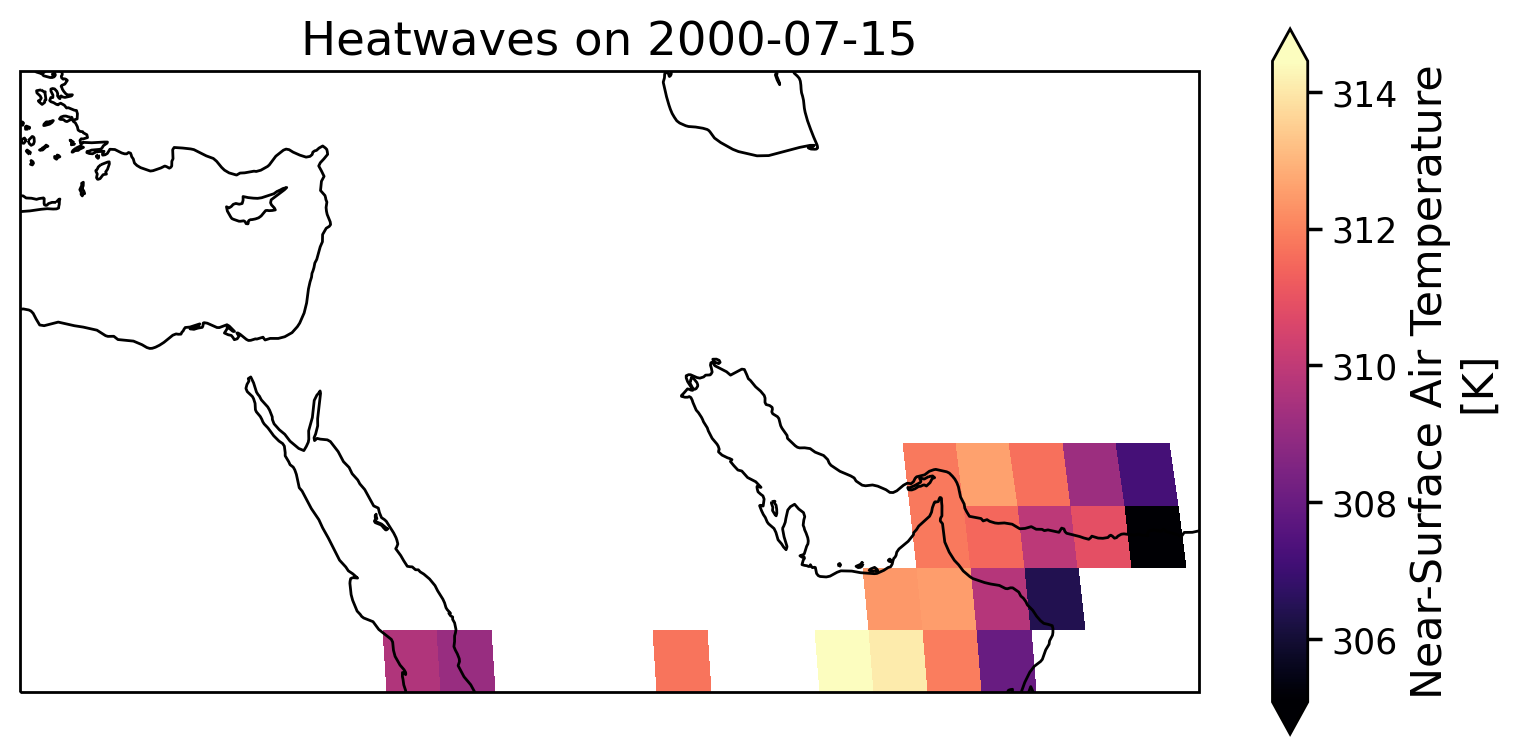

In [79]:
# TODO: add function for computing area
import datetime
from scipy.ndimage.measurements import label
import sys
def heatwave_over_region(tas_region, 
                         P95_mask_region, 
                         E, X, 
                         start_date=(2010, 7, 15), 
                         plotting=True,
                         mask_ocean=False):
    """
    tas_region: daily mean temperature of the region of interest for the year "year_ofinterest"
    P95_mask_region: mask of the region of interest for the year "year_ofinterest"
    E: minimum area (km^2) with tas>P95 for heatwave
    X: minmum number of days over which tas>P95
    """
    
    lat, lon, time = P95_mask_region.indexes.values()
    year, month, day = start_date
    start_date = datetime.date(year, month, day)
    end_date = datetime.date(year, month, day+X-1)
    # print((end_date.strftime('%Y-%m-%d')))
    tas_X_days = P95_mask_region.sel(time=slice(start_date.strftime('%Y-%m-%d'),
                                                end_date.strftime('%Y-%m-%d')),
                                     )
    tas_X_days_numpy = np.nan_to_num(tas_X_days.as_numpy())
    ht_array, num_ht = label(np.prod(tas_X_days_numpy, axis=0))
    # print(ht_array)
    for ii in range(num_ht):
        coords = np.argwhere(ht_array==(ii+1))
        print(coords)
        print(coords[:, 0])
        print(coords[:, 1])
        
        cell_lats = lat[coords[:, 0]]
        cell_lons = lon[coords[:, 1]]
        
        dst = tas_daily_mean.sel(time="2000").squeeze()  
        # 1980, 2000, start_date.strftime('%Y-%m-%d')
        area = 0
        for cell_lon in cell_lons:
            for cell_lat in cell_lats:
                area += get_area_of_cell_kmsqr(dst,
                                               cell_lat=cell_lat, 
                                               cell_lon=cell_lon)
        
        # area =  area(y, x) compute_area(lon, lat) # add function for computing area
        #area = 299 # dummy area
        print(area)
        if (area<E):
            for c_i in coords[:, 0]:
                for c_j in coords[:, 1]:
                    #print(c_i, c_j)
                    ht_array[c_i, c_j] = 0
            #ht_array[y, x] = 0
                    
    print(f"Number of heat waves recorded on the date {start_date}: {len(np.unique(ht_array))-1}")
    # uncomment if want to see output temperature array
    # print(np.nan_to_num(tas_region.sel(time=start_date.strftime('%Y-%m-%d')).squeeze().where(ht_array).as_numpy()))
    if plotting:
        fig, ax_present = plt.subplots(figsize=[8, 4], subplot_kw={"projection": ccrs.Robinson()})
        tas_region.sel(time=start_date.strftime('%Y-%m-%d')).squeeze().where(ht_array).plot(ax=ax_present, transform=ccrs.PlateCarree(), 
                                                                                            cmap="magma", robust=True)
        ax_present.coastlines()
        if mask_ocean:
            ax_present.add_feature(cart.feature.OCEAN, zorder=100, edgecolor='k')
        ax_present.set_title(f"Heatwaves on {start_date}")
        plt.show()

heatwave_over_region(tas_daily_mean_ME, 
                     tas_grtr_P95_ME, 
                     E=200**2, 
                     X=3, 
                     start_date=(year_ofinterest, 7, 15))